In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystan
import arviz

In [2]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
df = pd.DataFrame(bc.data, columns=bc.feature_names)
df["benign"]    = bc.target
df["malignant"] = df["benign"].apply(lambda x: 1 if x==0 else 0)

df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0,1


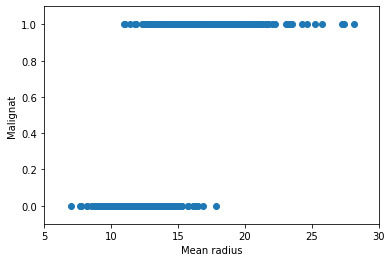

In [7]:
# 目的変数は Malignant
# 説明変数は mean Radius

plt.scatter(df["mean radius"], df["malignant"])
plt.xlabel("Mean radius")
plt.ylabel("Malignat")
plt.xlim([5, 30])
plt.ylim([-0.1, 1.1])
plt.show()

目的変数は Malignant (0 or 1), 説明変数は MeanRadius(連続変数) でロジスティック回帰のモデルを仮定する

Malignant ~ exp( a*MeanRadius + b ) // a, bはパラメーター

In [10]:
stan_model = """
data {
    int  N;
    real X[N];
    int<lower=0, upper=1> Y[N];
}

parameters {
    real a;
    real b;
}

model {
    for (n in 1:N) {
        Y[n] ~ bernoulli_logit( a*X[n] + b );
    }
}
"""

In [11]:
# モデルのコンパイル
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c911c8ed8b1d07b07eb9a9c3130efc4 NOW.


In [12]:
stan_data = {
    "N": df.shape[0],
    "X": df["mean radius"],
    "Y": df["malignant"]
}

fit = sm.sampling(data=stan_data, iter=3000, warmup=500, chains=3, seed=0)
print(fit)

Inference for Stan model: anon_model_6c911c8ed8b1d07b07eb9a9c3130efc4.
3 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=7500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      1.04  2.9e-3   0.09   0.86   0.98   1.04   1.11   1.23   1082    1.0
b    -15.39    0.04   1.34  -18.0 -16.28 -15.35 -14.49 -12.77   1077    1.0
lp__ -166.0    0.02    1.0 -168.6 -166.4 -165.7 -165.2 -165.0   1637    1.0

Samples were drawn using NUTS at Thu Jan 27 08:38:45 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


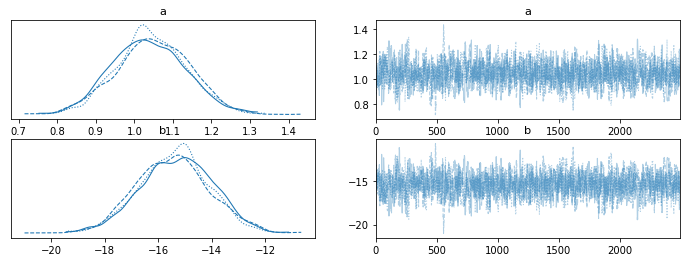

In [13]:
fig = arviz.plot_trace(fit)

In [14]:
ms_a = fit.extract('a')['a']
ms_b = fit.extract('b')['b']

x = np.linspace(0, 30, 100)
logistic_func = lambda x: 1.0 / (1.0+np.exp(-x))
df_lines = pd.DataFrame([])
for i in range(x.shape[0]):
    df_lines[i] = logistic_func(ms_a*x[i] + ms_b)

low_y50, high_y50 = mstats.mquantiles(df_lines, [0.25, 0.75], axis=0)
low_y99, high_y99 = mstats.mquantiles(df_lines, [0.005, 0.995], axis=0)

([<matplotlib.axis.YTick at 0x7f5f47a45ca0>,
 [Text(0, 0, ''), Text(0, 0, '')])

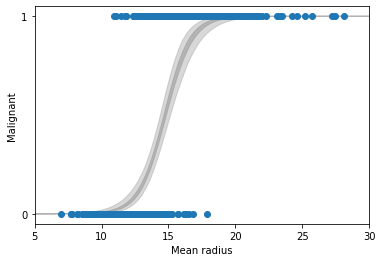

In [17]:
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color='darkgray')
plt.fill_between(x, low_y99, high_y99, alpha=0.3, color='gray')
#plt.plot(x, logistic_func(ms_a*x+ms_b))
plt.scatter(df['mean radius'], df['malignant'])
plt.xlabel('Mean radius')
plt.ylabel('Malignant')
plt.xlim([5, 30])
plt.yticks([0, 1])